# Downloading_sequences

In [ ]:
import os
from Bio import SeqIO
from Bio import Entrez

def download_genome_gff (accession_ids, outputfolder="."):
    Entrez.email = "20ilmb03@uohyd.ac.in"

    for accession_id in accession_ids:
        filename = os.path.join(output_folder, f"{accession_id}.fasta")

        if not os.path.isfile(filename):
            stream = Entrez.efetch(db="nucleotide", id=accession_id, rettype="fasta", retmode="text")
            with open(filename, "w") as record:
                record.write(stream.read())
            stream.close()
            print(f"Downloaded {accession_id} to {filename}")
        else:
            print(f"{accession_id} already exists.")

with open("/home/gokul/Desktop/Genomics_Basics/sequences/id.txt", "r") as file:
    accession_ids = [line.strip() for line in file.readlines()]

output_folder = "/home/gokul/Desktop/Genomics_Basics/sequences"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
download_genome_gff(accession_ids, output_folder)

# Creating a data frame.

In [ ]:

import pandas as pd

data = pd.DataFrame({'Accession ID': accession_ids})
print (data)

# Genome_size

In [ ]:
fasta_files = [str(accession) + ".fasta" for accession in accession_ids]

def calculate_genome_size(fasta_file):
    total_length = 0
    sequence_length = 0

    with open(fasta_file, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                continue
            else:
                sequence_length += len(line)
    sequence_length

    return sequence_length
genome_sizes_list = []

for fasta_file_path in fasta_files:
    genome_size = calculate_genome_size(f"/home/gokul/Desktop/Genomics_Basics/sequences/{fasta_file_path}")
    genome_sizes_list.append(genome_size)
data['Genome_size'] = genome_sizes_list
print(data)
#genome_size_dict = dict(zip(accession_ids, genome_sizes_list))
#print (genome_size_dict)

# GC Percentage

In [ ]:
def calculate_GC_percentage(fasta_file):
    sequence_length = 0
    G_C=0
    with open(fasta_file, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                continue
            else:
                for i in line:
                    if i == 'G'or i == 'C' or i == 'g' or i == 'c':
                        G_C+=1
                    else:
                        continue
                sequence_length += len(line)
    G_C_perc = (G_C/sequence_length)*100

    return G_C_perc
G_C_perc_list = []

for fasta_file_path in fasta_files:
    G_C_percentage = calculate_GC_percentage(f"/home/gokul/Desktop/Genomics_Basics/sequences/{fasta_file_path}")
    G_C_perc_list.append(G_C_percentage)
data['GC_percentage'] = G_C_perc_list
print(data)

# Parsing GFF3

In [ ]:
import pandas as pd

with open("/home/gokul/Desktop/Genomics_Basics/sequences/id.txt", "r") as file:
    accession_ids = [line.strip() for line in file.readlines()]
gff_files = [str(accession) + ".gff" for accession in accession_ids]

def parse_gff(gff_file_list):
    gff_dict = {}
    for file_path in gff_file_list:
        seqid_list = []
        source_list = []
        feature_type_list = []
        start_list = []
        end_list = []
        score_list = []
        strand_list = []
        phase_list = []
        attributes_list = []
        
        with open(f"/home/gokul/Desktop/Genomics_Basics/sequences/{file_path}", "r") as file:
            for line in file:
                line = line.strip()
                
                if line.startswith('#'):
                    continue
                else:
                    fields = line.split('\t')
                    if len(fields) >= 9:
                        seqid_list.append(fields[0])
                        source_list.append(fields[1])
                        feature_type_list.append(fields[2])
                        start_list.append(int(fields[3]))
                        end_list.append(int(fields[4]))
                        score_list.append(fields[5])
                        strand_list.append(fields[6])
                        phase_list.append(fields[7])
                        attributes_list.append(fields[8])
            gff_dict[f"{file_path}_df"] =  pd.DataFrame({'seqid': seqid_list,
                                               'source': source_list,
                                               'feature_type': feature_type_list,
                                               'start': start_list,
                                               'end': end_list,
                                               'score': score_list,
                                               'strand': strand_list,
                                               'phase': phase_list,
                                               'attributes': attributes_list})
        
    return gff_dict
gff_dict = parse_gff(gff_files)
print(gff_dict)

# Number of CDS

In [ ]:
import pandas as pd

def no_cds(gff_dict):
    gff_keys = [str(accession) + ".gff" +"_df" for accession in accession_ids]
    cds_list = []
    for keys in gff_keys:
        cds=0
        df1 = gff_dict[keys]
        for i in df1['feature_type']:
            if i == "CDS":
                cds+=1
            else:
                continue
        cds_list.append(cds)
    return cds_list

cds_list = no_cds(gff_dict)

data['Number_of_CDS'] = cds_list
print(data)

# Length of gene

In [ ]:
import pandas as pd

def length_gene(gff_dict):
    gene_length = []
    gff_keys = [str(accession) + ".gff" +"_df" for accession in accession_ids]
    for keys in gff_keys:
        
        data=gff_dict[keys]
        filtered_df = data[data['feature_type']=='gene'].copy()
        sorted_df = filtered_df.sort_values('start', ascending=True)
        sorted_df.reset_index(drop=True, inplace=True)
        i = sorted_df['start'][0]
        f = sorted_df['end'][0]
        lgth = 0
        for ind in sorted_df.index:
            if ind == 0:

                if ind == len(sorted_df.index) -1 :
                    lgth += f-i+1
                else:
                    continue
            else:
                if ind == len(sorted_df.index) -1 :
                    if sorted_df['start'][ind] > f:
                        lgth += f-i+1
                        i = sorted_df['start'][ind]
            
                    if sorted_df['end'][ind] > f:
                        f = sorted_df['start'][ind]
                    lgth += f-i+1
                else:
                    if sorted_df['start'][ind] > f:
                        lgth += f-i+1
                        i = sorted_df['start'][ind]
            
                    if sorted_df['end'][ind] > f:
                        f = sorted_df['start'][ind]
           
        
        gene_length.append(lgth)
    return gene_length
print (length_gene(gff_dict))
length_ = length_gene(gff_dict)
data['length_of_gene']= length_
print(data)

# Fraction of genome covered by CDS

In [ ]:
import pandas as pd

def length_cds(gff_dict):
    cds_length = []
    gff_keys = [str(accession) + ".gff" +"_df" for accession in accession_ids]
    for keys in gff_keys:
        
        data=gff_dict[keys]
        filtered_df = data[data['feature_type']=='CDS'].copy()
        sorted_df = filtered_df.sort_values('start', ascending=True)
        sorted_df.reset_index(drop=True, inplace=True)
        i = sorted_df['start'][0]
        f = sorted_df['end'][0]
        lgth = 0
        for ind in sorted_df.index:
            if ind == 0:

                if ind == len(sorted_df.index) -1 :
                    lgth += f-i+1
                else:
                    continue
            else:
                if ind == len(sorted_df.index) -1 :
                    if sorted_df['start'][ind] > f:
                        lgth += f-i+1
                        i = sorted_df['start'][ind]
            
                    if sorted_df['end'][ind] > f:
                        f = sorted_df['start'][ind]
                    lgth += f-i+1
                else:
                    if sorted_df['start'][ind] > f:
                        lgth += f-i+1
                        i = sorted_df['start'][ind]
            
                    if sorted_df['end'][ind] > f:
                        f = sorted_df['start'][ind]
           
        
        cds_length.append(lgth)
    return cds_length
print (length_cds(gff_dict))
length_ = length_cds(gff_dict)
data['length_of_cds']= length_
print(data)


# Size of 5' UTR

In [ ]:
import pandas as pd

def size_5_utr(gff_dict):
    gene_length = []
    gff_keys = [str(accession) + ".gff" +"_df" for accession in accession_ids]
    for keys in gff_keys:
        
        data=gff_dict[keys]
        filtered_df = data[data['feature_type']=='five_prime_UTR'].copy()
        filtered_df['sub'] = filtered_df['end']-filtered_df['start'] + 1
        res_li=filtered_df['sub'].tolist()
        
        summation= sum(res_li)
        gene_length.append(summation)
    return gene_length

length_ = size_5_utr(gff_dict)
data["Size of 5' UTR"]= length_
print(data)

# Size of 3' UTR

In [ ]:
import pandas as pd

def size_3_utr(gff_dict):
    gene_length = []
    gff_keys = [str(accession) + ".gff" +"_df" for accession in accession_ids]
    for keys in gff_keys:
        
        data=gff_dict[keys]
        filtered_df = data[data['feature_type']=='three_prime_UTR'].copy()
        filtered_df['sub'] = filtered_df['end']-filtered_df['start'] + 1
        res_li=filtered_df['sub'].tolist()
        
        summation= sum(res_li)
        gene_length.append(summation)
    return gene_length

length_ = size_3_utr(gff_dict)
data["Size of 3' UTR"]= length_
print(data)

   Accession ID  Genome_size  GC_percentage  Number_of_CDS  length_of_gene  \
0   NC_075037.1      1016844      24.715492            976            1057   
1   NC_021858.1      1908524      63.663962           1189            2232   
2   NC_023423.1       610033      35.798391            468            1135   
3   NC_037057.1       181035      52.726268            227             371   
4   NC_044945.1       191058      38.252258            168            1238   
5   NC_037656.1       127879      31.279569            132             995   
6   NC_044939.1       199721      45.845454            194            3454   
7   NC_001824.1       102653      29.070753            110             465   
8   NC_006273.2       235646      57.482410            188            1230   
9   NC_002331.1       178733      40.678554            181             927   
10  NC_001460.1        34125      46.523077             42            1037   
11  NC_010537.1        41172      34.644904             73      

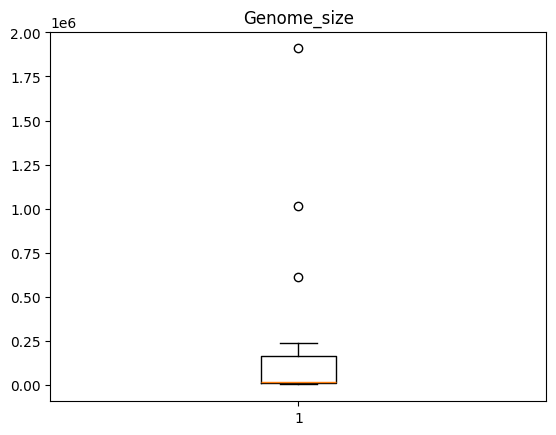

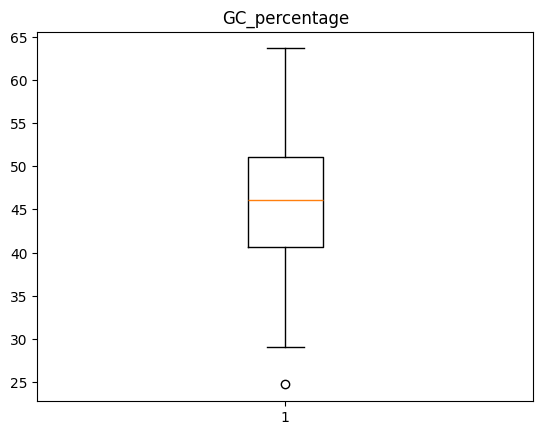

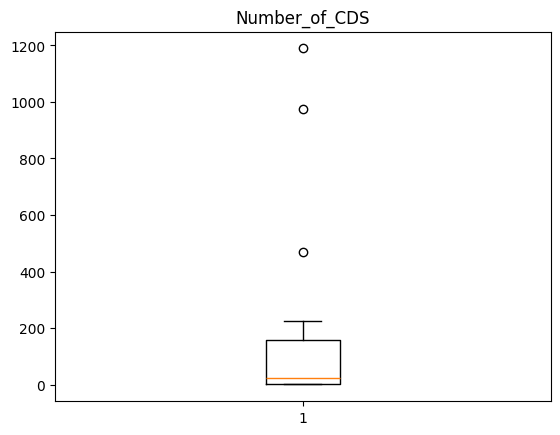

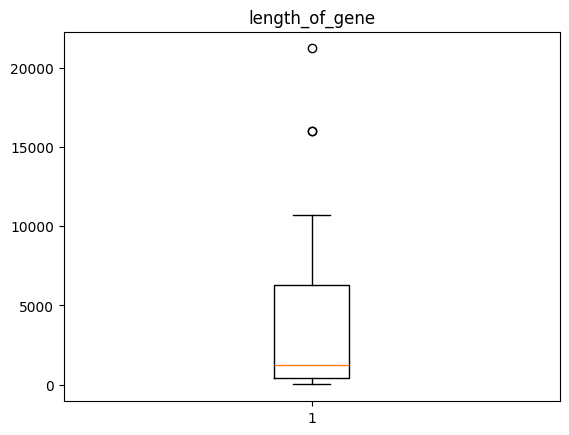

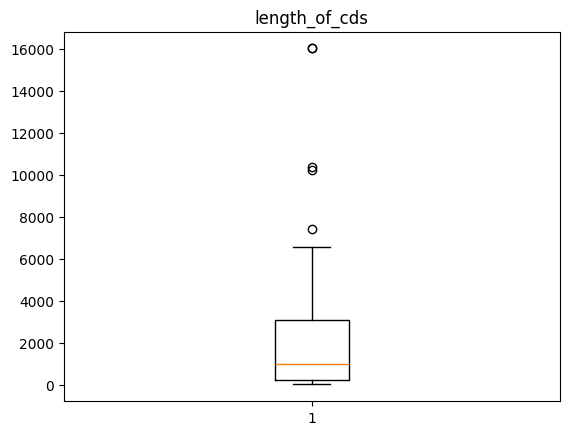

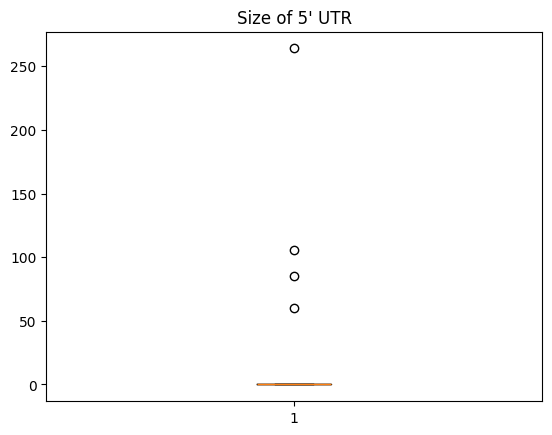

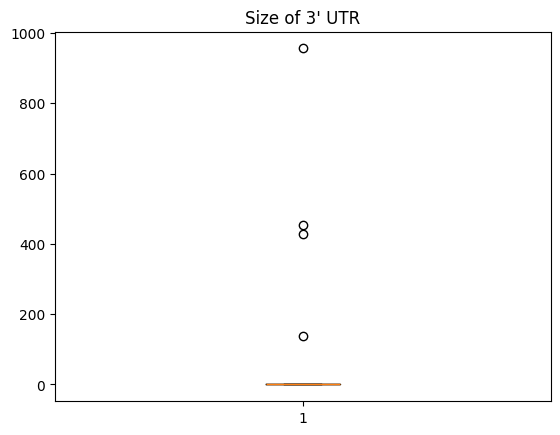

In [16]:
import matplotlib.pyplot as plt

print(data)

for col in data.columns[1:]:
    plt.boxplot(data[col])
    plt.title(col)
    plt.show()